<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)
* [Humidity](#humidity)
* [Solar radiation](#solar_radiation)
* Air quality deterioration
### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)
* Coastal erosion
* Soil erosion
* Soil salinity
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Seawater temperature](#sea_water_temperature)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* Storms
* Dust storms
* Wildfire
* Urban heat island
* Growinf season length
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com

<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [1]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

## Import python packages

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D
import seaborn as sns

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name

from Functions_Indicators import temporal_avg
from Functions_Indicators import temporal_max
from Functions_Indicators import df_stat_distr
from Functions_Indicators import number_day_above_threshold
from Functions_Indicators import filter_dataframe
from Functions_Indicators import changes_in_indicators
from Functions_Indicators import dataframe_n_day_event
from Functions_Indicators import dataframe_max_5_days_event
from Functions_Indicators import level_exposure
from Functions_Indicators import vulnerability
from Functions_Indicators import dataframe_threshold_coresponding_to_return_period_model
from Functions_Indicators import dataframe_return_period_coresponding_to_past_100year_event_model

from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import sensitivity
from Functions_ImportData import import_BC_NOAA_NEX_GDDP_CMIP6

from Graphs_functions import plot_lines

from Functions_likelihood import likelihood_accross_models
from Functions_likelihood import likelihood_accross_models_and_ssps

from Functions_exposure import look_best_distr
from Functions_exposure import range_likelihood

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_25396\862487899.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<a id='load_shapefile'></a>
## Load shapefiles and plot

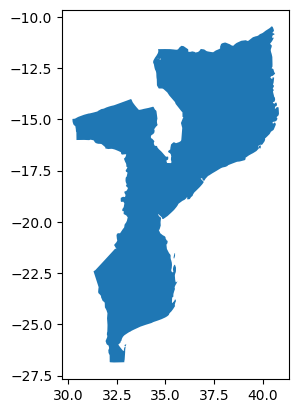

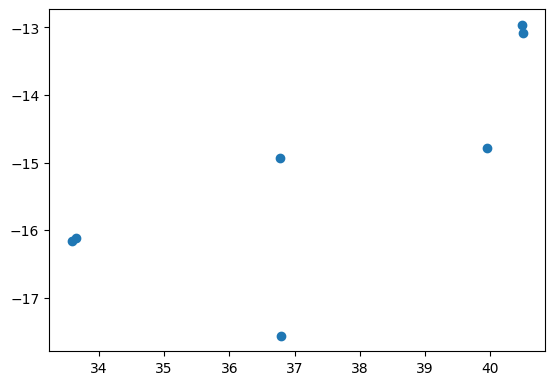

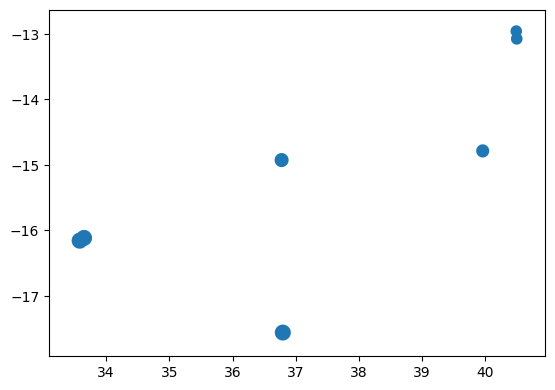

In [4]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus
first_year=1950
last_year =2100
### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index or dates vector

In [5]:
# name project in mozambique, those ones were added in the shp (there were initially not in the shapefile)
name_projects = np.array(['WTP_Mutua_EIB', 'Gorongosa_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB'])

lon_projects_data = np.array([34.5927839939706, 34.07824286310398 , 33.47333313659342, 40.52545156033736]) # decimal degrees
lon_projects = pd.Series(lon_projects_data)

lat_projects_data = np.array([-19.495079648575242, -18.68063728746643, -19.125095255188334,-12.973942656747809]) # decimal degrees
lat_projects = pd.Series(lat_projects_data) 
buffer_area_project=2
area_projects = [lat_projects - buffer_area_project, lat_projects+buffer_area_project, lon_projects-buffer_area_project,lon_projects+buffer_area_project] # list format

# elevation above sea level 
elevation_asl_data = np.array([15, 383, 723, 47]) # unit m 
elevation_asl = pd.Series(elevation_asl_data) # unit m 

# add informations of projects in one dataframe
infos_projects = pd.DataFrame()
infos_projects['Name project'] = name_projects
infos_projects['Longitude DD'] = lon_projects
infos_projects['Latitude DD'] = lat_projects
infos_projects['Elevation above sea level m'] = elevation_asl
infos_projects

,Name project,Longitude DD,Latitude DD,Elevation above sea level m
0,WTP_Mutua_EIB,34.592784,-19.495080,15
1,Gorongosa_EIB,34.078243,-18.680637,383
2,Chimoio_WTP_EIB,33.473333,-19.125095,723
3,Pemba_EIB,40.525452,-12.973943,47


<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

In [ ]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'


#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()

## Temperature - Not BC

By comparing NEX GDDP CMIP6 data to observed data, we know that the models 'TAIESM1' and 'CMCC-CM2-SR5' do not comply to the observed data. We are taking them off the analysis.
A bias correction does not better the queality of the data. It follows oberved data enough

In [6]:
df_tas_NEXGDDPCMIP6=import_treat_modeled_NEX_GDDP_CMIP6('tas','Celsius','day',1950,2100)

In [ ]:
df_tas_NEXGDDPCMIP6_gorongosa = filter_dataframe(df_tas_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'])

In [ ]:
df_tas_NEXGDDPCMIP6_all_projects = filter_dataframe(df_tas_NEXGDDPCMIP6,list(set(df_tas_NEXGDDPCMIP6['Name project'])),['TaiESM1','CMCC-CM2-SR5'])

### Incremental air temperature change BC

In [ ]:
# calculate mean per year for gorongosa 
df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa=temporal_avg(df_tas_NEXGDDPCMIP6_gorongosa,'temperature','Yearly average temperature','year')

#### Vulnerability - Exposure

In [ ]:
# statistical distribution for temperature past and future
df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()[df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()['Year'].between(1970,2014)][['Name project','Yearly average temperature']])
df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()[df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()['Year'].between(2030,2074)][['Name project','Yearly average temperature']])

df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_past
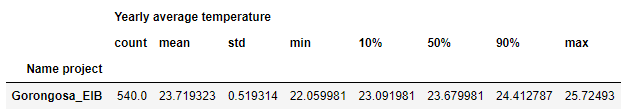

df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_future
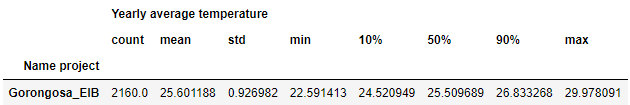

In [ ]:
changes_past_future_indicator_tas=changes_in_indicators(df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_yearly_avg_tas_NEXGDDPCMIP6_gorongosa_future,'Mean temperature per year', '°C','Incremental temperature increase')

changes_past_future_indicator_tas
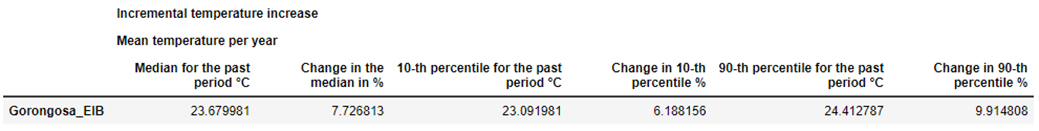

#### Risk assessment - Likelihood

In [ ]:
# as the elements of the project is not vulnerable regarding yearly temperature, no need to do risk assessment
(proba_event_accross_model_and_ssp_gorongosa_tas,likelihood_accross_model_and_ssp_gorongosa_tas)=likelihood_accross_models_and_ssps(df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()[df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()['Year'].between(2030,2074)],'tas','°C','Yearly average temperature',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_tas # 6.93085588542946e-08

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_tas # Rare

### Extreme temperature increase

In [ ]:
df_tasmax_NEXGDDPCMIP6 = import_treat_modeled_NEX_GDDP_CMIP6('tasmax','Celsius','day',1950,2100)

In [ ]:
df_tasmax_NEXGDDPCMIP6_past = filter_dataframe(df_tasmax_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=1970,stop_y=2014)

In [ ]:
df_tasmax_NEXGDDPCMIP6_future = filter_dataframe(df_tasmax_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=2030,stop_y=2074)

In [ ]:
# maximum daily temperature

#### Vulnerability - Exposure - Event : Daily maximum temperature above 40 °

In [ ]:
# statistical distribution for daily maximum temperature past and future
df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_tasmax_NEXGDDPCMIP6_past[['Name project','Daily Maximum Near-Surface Air Temperature °C']])
df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_tasmax_NEXGDDPCMIP6_future[['Name project','Daily Maximum Near-Surface Air Temperature °C']])

df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_past
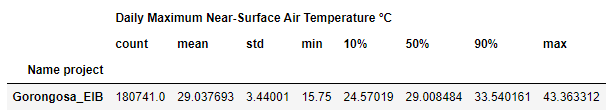

df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_future
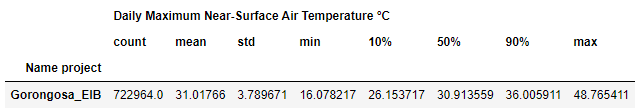

In [ ]:
changes_past_future_indicator_tasmax=changes_in_indicators(df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_tasmax_NEXGDDPCMIP6_gorongosa_future,'Daily maximum temperature', '°C','Extreme temperature increase')

changes_past_future_indicator_tasmax
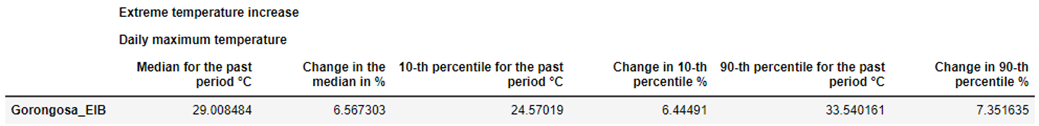

In [ ]:
df = pd.DataFrame()

In [ ]:
df = pd.concat([changes_past_future_indicator_tas,changes_past_future_indicator_tasmax],axis=1)
df

#### Risk - Likelihood - Daily maximum temperature above 40 °

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_tasmax_daily,likelihood_accross_model_and_ssp_gorongosa_tasmax_daily)=likelihood_accross_models_and_ssps(df_tasmax_NEXGDDPCMIP6_future[['Experiment','Model','Daily Maximum Near-Surface Air Temperature °C']].dropna(),'tasmax','°C','Daily Maximum Near-Surface Air Temperature °C',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_tasmax_daily # result : 0.01264346317692103

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_tasmax_daily # result Rare

### maximum temperature in year

In [ ]:
df_tasmax_NEXGDDPCMIP6_past_max_per_year= temporal_max(df_tasmax_NEXGDDPCMIP6_past[['Name project','Experiment','Model','Year','Daily Maximum Near-Surface Air Temperature °C']],'temperature','Daily Maximum Near-Surface Air Temperature °C','year')

In [ ]:
df_tasmax_NEXGDDPCMIP6_future_max_per_year= temporal_max(df_tasmax_NEXGDDPCMIP6_future[['Name project','Experiment','Model','Year','Daily Maximum Near-Surface Air Temperature °C']],'temperature','Daily Maximum Near-Surface Air Temperature °C','year')

In [ ]:
df_tasmax_NEXGDDPCMIP6_future_max_per_year = df_tasmax_NEXGDDPCMIP6_future_max_per_year.rename(columns={'Daily Maximum Near-Surface Air Temperature °C':'Yearly Maximum Near-Surface Air Temperature °C'})

In [ ]:
df_tasmax_NEXGDDPCMIP6_past_max_per_year = df_tasmax_NEXGDDPCMIP6_past_max_per_year.rename(columns={'Daily Maximum Near-Surface Air Temperature °C':'Yearly Maximum Near-Surface Air Temperature °C'})

#### Vulnerability - Exposure - Maximum temperature per year

In [ ]:
df_stat_distr_max_temp_past=df_stat_distr(df_tasmax_NEXGDDPCMIP6_past_max_per_year.reset_index()[['Name project','Yearly Maximum Near-Surface Air Temperature °C']])
df_stat_distr_max_temp_future=df_stat_distr(df_tasmax_NEXGDDPCMIP6_future_max_per_year.reset_index()[['Name project','Yearly Maximum Near-Surface Air Temperature °C']])

df_stat_distr_max_temp_past
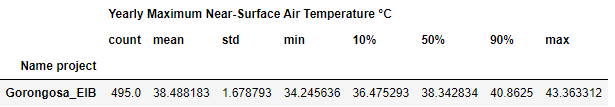

df_stat_distr_max_temp_future
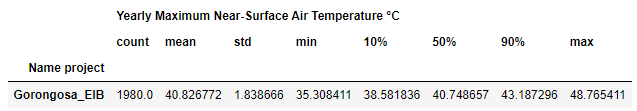

In [ ]:
changes_past_future_indicator_tasmax_yearly_max=changes_in_indicators(df_stat_distr_max_temp_past,df_stat_distr_max_temp_future,'Yearly maximum temperature', '°C','Extreme temperature increase')

changes_past_future_indicator_tasmax_yearly_max
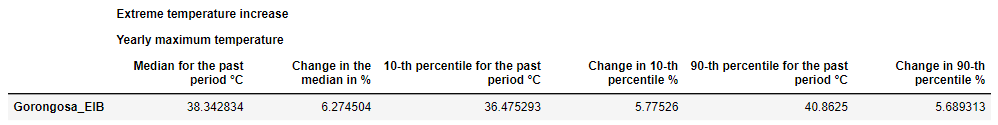

In [ ]:
df = pd.concat([df,changes_past_future_indicator_tasmax_yearly_max],axis=1)

#### Risk - Likelihood, temperature above 40 degrees

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_tasmax_yearly,likelihood_accross_model_and_ssp_gorongosa_tasmax_yearly)=likelihood_accross_models_and_ssps(df_tasmax_NEXGDDPCMIP6_future_max_per_year.reset_index()[['Experiment','Model','Daily Maximum Near-Surface Air Temperature °C']].dropna(),'tasmax','°C','Daily Maximum Near-Surface Air Temperature °C',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_tasmax_yearly*100 # 0.6629380428544061

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_tasmax_yearly # 'Likely'

### Number of days above 40 - as done in ccpk, work with max temp

In [ ]:
df_tasmax_NEXGDDPCMIP6_past_days_above_40 = number_day_above_threshold(df_tasmax_NEXGDDPCMIP6_past,'Maximum Temperature','Daily Maximum Near-Surface Air Temperature °C',40)

In [ ]:
df_tasmax_NEXGDDPCMIP6_future_days_above_40 = number_day_above_threshold(df_tasmax_NEXGDDPCMIP6_future,'Maximum Temperature','Daily Maximum Near-Surface Air Temperature °C',40)

#### Vulnerability - Number of days above 40 

In [ ]:
df_stat_distr_max_temp_past_days_above_40=df_stat_distr(df_tasmax_NEXGDDPCMIP6_past_days_above_40.reset_index()[['Name project','Average annual number of days with Maximum Temperature above 40']])
df_stat_distr_max_temp_future_days_above_40=df_stat_distr(df_tasmax_NEXGDDPCMIP6_future_days_above_40.reset_index()[['Name project','Average annual number of days with Maximum Temperature above 40']])

In [ ]:
df_stat_distr_max_temp_past_days_above_40

In [ ]:
df_stat_distr_max_temp_future_days_above_40

In [ ]:
changes_past_future_indicator_tasmax_days_above_40=changes_in_indicators(df_stat_distr_max_temp_past_days_above_40,df_stat_distr_max_temp_future_days_above_40,'Number of days with maximum temperature above 40°C', '[-]','Extreme temperature increase')

In [ ]:
changes_past_future_indicator_tasmax_days_above_40

In [ ]:
changes_past_future_indicator_tasmax_days_above_40[[('Extreme temperature increase','Number of days with maximum temperature above 40°C','Change in the median in %')]]='Low'

In [ ]:
changes_past_future_indicator_tasmax_days_above_40[[('Extreme temperature increase','Number of days with maximum temperature above 40°C','Change in 10-th percentile %')]]='Low'

In [ ]:
changes_past_future_indicator_tasmax_days_above_40[[('Extreme temperature increase','Number of days with maximum temperature above 40°C','Change in 90-th percentile %')]]='Medium'

In [ ]:
changes_past_future_indicator_tasmax_days_above_40

changes_past_future_indicator_tasmax_days_above_40
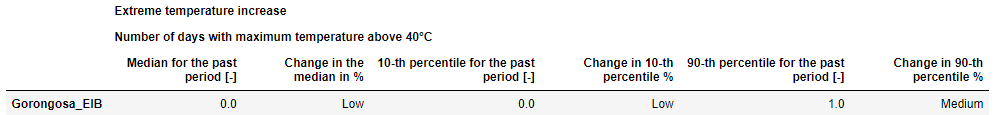

In [ ]:
df = pd.concat([df,changes_past_future_indicator_tasmax_days_above_40],axis=1)

#### Risk - Likelihood, temperature above 40 degrees

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_tasmax_above40,likelihood_accross_model_and_ssp_gorongosa_tasmax_above40)=likelihood_accross_models_and_ssps(df_tasmax_NEXGDDPCMIP6_future_days_above_40.reset_index()[['Experiment','Model','Average annual number of days with Maximum Temperature above 40']].dropna(),'tasmax','°C','Average annual number of days with Maximum Temperature above 40',30,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_tasmax_above40 # more than 30 number of days above 40 degrees per year : 0.028626984761512878

In [ ]:
0.028626984761512878*100

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_tasmax_above40 # more than 30 number of days above 40 degrees per year :'Rare'

### Exposure and vulnerability

In [ ]:
ExposureLevel_ = level_exposure(df)
df_sen = sensitivity()
df_v = vulnerability(df_sen,ExposureLevel_)

In [ ]:
df_v

In [ ]:
ExposureLevel_

Exposure level
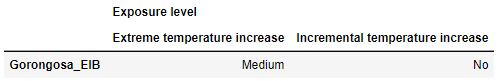
df_v 
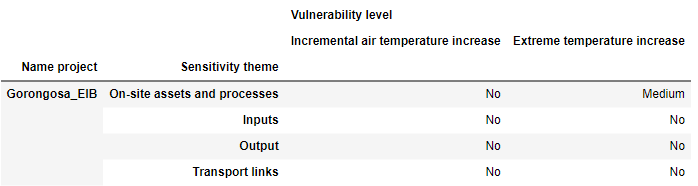

## BC temperature data

### import data

In [ ]:
# import and filter BC average temperature data
df_tas_NEXGDDPCMIP6_BC_past=import_BC_NOAA_NEX_GDDP_CMIP6('tas',1970,2014,EmplacementStationNOAA='no')
df_tas_NEXGDDPCMIP6_BC_past_gorongosa = filter_dataframe(df_tas_NEXGDDPCMIP6_BC_past,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'])
df_tas_NEXGDDPCMIP6_BC_future=import_BC_NOAA_NEX_GDDP_CMIP6('tas',2030,2074,EmplacementStationNOAA='no')
df_tas_NEXGDDPCMIP6_BC_future_gorongosa = filter_dataframe(df_tas_NEXGDDPCMIP6_BC_future,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'])

In [ ]:
# import and filter BC maximum temperature data
df_tasmax_NEXGDDPCMIP6_BC_past=import_BC_NOAA_NEX_GDDP_CMIP6('tasmax',1970,2014,EmplacementStationNOAA='no')
df_tasmax_NEXGDDPCMIP6_BC_past_gorongosa = filter_dataframe(df_tasmax_NEXGDDPCMIP6_BC_past,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'])
df_tasmax_NEXGDDPCMIP6_BC_future=import_BC_NOAA_NEX_GDDP_CMIP6('tasmax',2030,2074,EmplacementStationNOAA='no')
df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa = filter_dataframe(df_tasmax_NEXGDDPCMIP6_BC_future,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'])

### Incremental air temperature change

In [ ]:
# calculate mean per year for gorongosa 
df_yearly_avg_BC_tas_NEXGDDPCMIP6_past_gorongosa=temporal_avg(df_tas_NEXGDDPCMIP6_BC_past_gorongosa,'temperature','Yearly average temperature','year')
df_yearly_avg_BC_tas_NEXGDDPCMIP6_future_gorongosa=temporal_avg(df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa,'temperature','Yearly average temperature','year')

#### vulnerability

In [ ]:
# statistical distribution for temperature past and future
df_stat_distr_yearly_avg_tas_BC_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_yearly_avg_BC_tas_NEXGDDPCMIP6_past_gorongosa.reset_index()[['Name project','Yearly average temperature']])
df_stat_distr_yearly_avg_tas_BC_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_yearly_avg_tas_NEXGDDPCMIP6_gorongosa.reset_index()[['Name project','Yearly average temperature']])

In [ ]:
changes_past_future_indicator_BC_tas=changes_in_indicators(df_stat_distr_yearly_avg_tas_BC_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_yearly_avg_tas_BC_NEXGDDPCMIP6_gorongosa_future,'Mean temperature per year', '°C','Incremental temperature increase')

#### likelihood

In [ ]:
# as the elements of the project is not vulnerable regarding yearly temperature, no need to do risk assessment
(proba_event_accross_model_and_ssp_gorongosa_BC_tas,likelihood_accross_model_and_ssp_gorongosa_BC_tas)=likelihood_accross_models_and_ssps(df_yearly_avg_BC_tas_NEXGDDPCMIP6_future_gorongosa.reset_index(),'tasmax','°C','Yearly average temperature',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_BC_tas # 0.0009692383121501044

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_BC_tas # Rare

### Extreme temperature increase BC

#### Vulnerability - Exposure - Event : Daily maximum temperature above 40 °

In [ ]:
# statistical distribution for daily maximum temperature past and future
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_tasmax_NEXGDDPCMIP6_BC_past_gorongosa[['Name project','Daily Maximum Near-Surface Air Temperature °C']])
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa[['Name project','Daily Maximum Near-Surface Air Temperature °C']])

In [ ]:
changes_past_future_indicator_BC_tasmax_daily_max=changes_in_indicators(df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future,'Daily maximum temperature', '°C','Extreme temperature increase')

In [ ]:
df_BC = pd.concat([changes_past_future_indicator_BC_tas,changes_past_future_indicator_BC_tasmax_daily_max],axis=1)

#### Risk - Likelihood - Daily maximum temperature above 40 °

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_daily,likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_daily)=likelihood_accross_models_and_ssps(df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa[['Experiment','Model','Daily Maximum Near-Surface Air Temperature °C']].dropna(),'tasmax','°C','Daily Maximum Near-Surface Air Temperature °C',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_daily

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_daily

### Maximum temperature per year

In [ ]:
df_BC_tasmax_NEXGDDPCMIP6_past_max_per_year= temporal_max(df_tasmax_NEXGDDPCMIP6_BC_past_gorongosa[['Name project','Experiment','Model','Year','Daily Maximum Near-Surface Air Temperature °C']],'temperature','Daily Maximum Near-Surface Air Temperature °C','year')
df_BC_tasmax_NEXGDDPCMIP6_future_max_per_year= temporal_max(df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa[['Name project','Experiment','Model','Year','Daily Maximum Near-Surface Air Temperature °C']],'temperature','Daily Maximum Near-Surface Air Temperature °C','year')

In [ ]:
df_BC_tasmax_NEXGDDPCMIP6_past_max_per_year

#### Vulnerability - Exposure - Maximum temperature per year

In [ ]:
# statistical distribution for daily maximum temperature past and future
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past_max_per_year = df_stat_distr(df_BC_tasmax_NEXGDDPCMIP6_past_max_per_year.reset_index()[['Name project','Daily Maximum Near-Surface Air Temperature °C']])
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future_max_per_year = df_stat_distr(df_BC_tasmax_NEXGDDPCMIP6_future_max_per_year.reset_index()[['Name project','Daily Maximum Near-Surface Air Temperature °C']])

In [ ]:
changes_past_future_indicator_BC_tasmax_yearly_max=changes_in_indicators(df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past_max_per_year,df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future_max_per_year,'Daily maximum temperature', '°C','Extreme temperature increase')

In [ ]:
df_BC = pd.concat([df_BC,changes_past_future_indicator_BC_tasmax_yearly_max],axis=1)

#### Risk - Likelihood, temperature above 40 degrees

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_max_yearly,likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_max_yearly)=likelihood_accross_models_and_ssps(df_BC_tasmax_NEXGDDPCMIP6_future_max_per_year.reset_index()[['Experiment','Model','Daily Maximum Near-Surface Air Temperature °C']].dropna(),'tasmax','°C','Daily Maximum Near-Surface Air Temperature °C',40,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_max_yearly

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_max_yearly

### Number of days above 40 - as done in ccpk, work with max temp

In [ ]:
df_tasmax_BC_NEXGDDPCMIP6_past_days_above_40 = number_day_above_threshold(df_tasmax_NEXGDDPCMIP6_BC_past_gorongosa,'Maximum Temperature','Daily Maximum Near-Surface Air Temperature °C',40)

In [ ]:
df_tasmax_BC_NEXGDDPCMIP6_future_days_above_40 = number_day_above_threshold(df_tasmax_NEXGDDPCMIP6_BC_future_gorongosa,'Maximum Temperature','Daily Maximum Near-Surface Air Temperature °C',40)

#### Vulnerability

In [ ]:
# statistical distribution for daily maximum temperature past and future
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past_days_above_40 = df_stat_distr(df_tasmax_BC_NEXGDDPCMIP6_past_days_above_40.reset_index()[['Name project','Average annual number of days with Maximum Temperature above 40']])
df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future_days_above_40 = df_stat_distr(df_tasmax_BC_NEXGDDPCMIP6_future_days_above_40.reset_index()[['Name project','Average annual number of days with Maximum Temperature above 40']])

In [ ]:
changes_past_future_indicator_BC_tasmax_days_above_40=changes_in_indicators(df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_past_days_above_40,df_stat_distr_BC_tasmax_NEXGDDPCMIP6_gorongosa_future_days_above_40,'Daily maximum temperature', '°C','Extreme temperature increase')

In [ ]:
df_BC = pd.concat([df_BC,changes_past_future_indicator_BC_tasmax_days_above_40],axis=1)

#### Risk - Likelihood, temperature above 40 degrees

In [ ]:
(proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_days_above40,likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_days_above40)=likelihood_accross_models_and_ssps(df_tasmax_BC_NEXGDDPCMIP6_future_days_above_40.reset_index()[['Experiment','Model','Daily Maximum Near-Surface Air Temperature °C']].dropna(),'tasmax','°C','Daily Maximum Near-Surface Air Temperature °C',30,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_BC_tasmax_days_above40

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_BC_tasmax_days_above40

#### Exposure and vulnerability

In [ ]:
ExposureLevel_BC = level_exposure(df_BC)
df_sen = sensitivity()
df_v_BC = vulnerability(df_sen,ExposureLevel_BC)

In [ ]:
df_v_BC

## Precipitation not BC

In [7]:
# import data
df_pr_NEXGDDPCMIP6=import_treat_modeled_NEX_GDDP_CMIP6('pr','mm_per_day','day',1950,2100)
df_pr_NEXGDDPCMIP6_gorongosa_past = filter_dataframe(df_pr_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=1970,stop_y=2014)
df_pr_NEXGDDPCMIP6_gorongosa_future = filter_dataframe(df_pr_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=2030,stop_y=2074)

### Average monthly precipitation

In [8]:
df_monthly_pr_NEXGDDPCMIP6_gorongosa_past=temporal_avg(df_pr_NEXGDDPCMIP6_gorongosa_past,'precipitation','Monthly average precipitation','month')
df_monthly_pr_NEXGDDPCMIP6_gorongosa_future=temporal_avg(df_pr_NEXGDDPCMIP6_gorongosa_future,'precipitation','Monthly average precipitation','month')

In [9]:
df_monthly_pr_NEXGDDPCMIP6_gorongosa_past

Monthly average precipitation
Name project  Experiment Model      Month                               
Gorongosa_EIB historical ACCESS-CM2 Apr                        72.115386
                                    Aug                        18.887333
                                    Dec                       212.230577
                                    Feb                       218.801852
                                    Jan                       237.133677
...                                                                  ...
                         NorESM2-MM Mar                       182.609282
                                    May                        36.422696
                                    Nov                        85.401834
                                    Oct                        26.634564
                                    Sep                        14.318396

[144 rows x 1 columns]

#### Vulnerability

In [10]:
# statistical distribution for monthly average precipitation past and future
df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_monthly_pr_NEXGDDPCMIP6_gorongosa_past.reset_index()[['Name project','Monthly average precipitation']])
df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_monthly_pr_NEXGDDPCMIP6_gorongosa_future.reset_index()[['Name project','Monthly average precipitation']])

In [11]:
df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_past

Monthly average precipitation                                  \
                                      count      mean        std        min   
Name project                                                                  
Gorongosa_EIB                         144.0  93.99875  83.583233  13.480124   

                                                             
                     10%        50%         90%         max  
Name project                                                 
Gorongosa_EIB  17.439167  48.333581  219.930042  242.215202

In [12]:
df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_future

Monthly average precipitation                                  \
                                      count       mean        std       min   
Name project                                                                  
Gorongosa_EIB                         576.0  86.922832  83.182211  8.003278   

                                                             
                     10%        50%         90%         max  
Name project                                                 
Gorongosa_EIB  14.000761  40.387648  220.517608  274.943102

In [13]:
changes_past_future_indicator_monthly_pr_NEXGDDPCMIP6_gorongosa=changes_in_indicators(df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_monthly_pr_NEXGDDPCMIP6_gorongosa_future,'Monthly average precipitation', 'mm per month','Incremental rainfall change')

In [14]:
changes_past_future_indicator_monthly_pr_NEXGDDPCMIP6_gorongosa

Incremental rainfall change  \
                        Monthly average precipitation   
              Median for the past period mm per month   
Gorongosa_EIB                               48.333581   

                                         \
                                          
              Change in the median in %   
Gorongosa_EIB                -16.439777   

                                                                 \
                                                                  
              10-th percentile for the past period mm per month   
Gorongosa_EIB                                         17.439167   

                                            \
                                             
              Change in 10-th percentile %   
Gorongosa_EIB                   -19.716568   

                                                                 \
                                                                  
              90-th percentile for the past period mm per month   
Gorongosa_EIB                                        219.930042   

                                            
                                            
              Change in 90-th percentile %  
Gorongosa_EIB                     0.267161

### Average wet seasonal precipitation

In [40]:
df_wetSeason_pr_NEXGDDPCMIP6_gorongosa_past=temporal_avg(df_pr_NEXGDDPCMIP6_gorongosa_past[df_pr_NEXGDDPCMIP6_gorongosa_past['Season']=='Humid'],'precipitation','Wet season monthly average precipitation mm','month')
df_wetSeason_pr_NEXGDDPCMIP6_gorongosa_future=temporal_avg(df_pr_NEXGDDPCMIP6_gorongosa_future[df_pr_NEXGDDPCMIP6_gorongosa_future['Season']=='Humid'],'precipitation','Wet season monthly average precipitation mm','month')

#### Vulnerability

In [41]:
# statistical distribution for daily maximum temperature past and future
df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_wetSeason_pr_NEXGDDPCMIP6_gorongosa_past.reset_index()[['Name project','Wet season monthly average precipitation mm']])
df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_wetSeason_pr_NEXGDDPCMIP6_gorongosa_future.reset_index()[['Name project','Wet season monthly average precipitation mm']])

df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_past
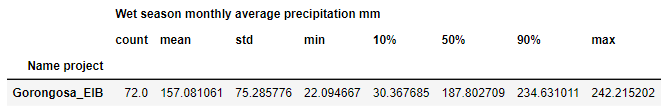

df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_future
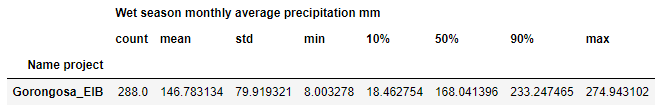

In [44]:
changes_past_future_indicator_monthlyWetSeason_pr_NEXGDDPCMIP6_gorongosa=changes_in_indicators(df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_wetSeason_pr_NEXGDDPCMIP6_gorongosa_future,'Monthly average precipitation during wet season', 'mm per month','Incremental rainfall change')

changes_past_future_indicator_monthlyWetSeason_pr_NEXGDDPCMIP6_gorongosa
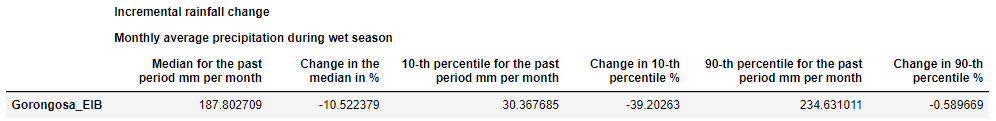

### Maximum 5 day rainfall

In [21]:
df_pr_NEXGDDPCMIP6_gorongosa_past_5_day_event=dataframe_max_5_days_event(df_pr_NEXGDDPCMIP6_gorongosa_past,5)

Project Gorongosa_EIB, scenario historical, model MIROC6
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
Project Gorongosa_EIB, scenario historical, model MPI-ESM1-2-LR
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
Project Gorongosa_EIB, scenario historical, model MRI-ESM2-0
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
Project Gorongosa_EIB, scenario historical, model BCC-CSM2-MR
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1

In [22]:
df_pr_NEXGDDPCMIP6_gorongosa_future_5_day_event=dataframe_max_5_days_event(df_pr_NEXGDDPCMIP6_gorongosa_future,5)

Project Gorongosa_EIB, scenario ssp245, model MIROC6
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp245, model MPI-ESM1-2-LR
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp245, model MRI-ESM2-0
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp245, model BCC-CSM2-MR
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
20

2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp585, model MPI-ESM1-2-HR
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp585, model NorESM2-LM
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp585, model ACCESS-CM2
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
Project Gorongosa_EIB, scenario ssp585, model ACCES

#### Vulnerability

In [23]:
# statistical distribution for temperature past and future
df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_pr_NEXGDDPCMIP6_gorongosa_past_5_day_event.reset_index()[['Name project','5 days rainfall mm']])
df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_pr_NEXGDDPCMIP6_gorongosa_future_5_day_event.reset_index()[['Name project','5 days rainfall mm']])

df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_past
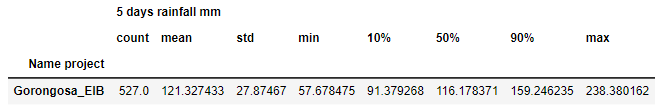

df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_future
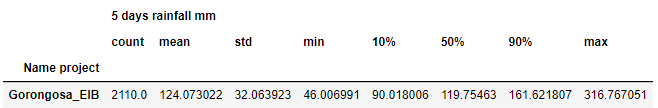

In [24]:
changes_past_future_indicator_5dayevent_pr=changes_in_indicators(df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_5dayevent_pr_NEXGDDPCMIP6_gorongosa_future,'Maximum five days rainfall', 'mm','Extreme rainfall change')

changes_past_future_indicator_5dayevent_pr
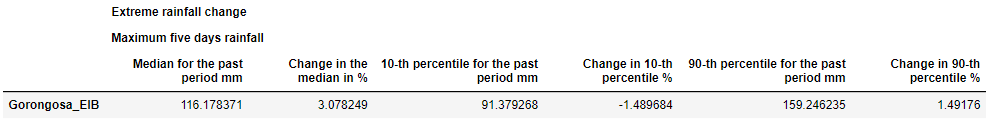

In [25]:
df_pr=pd.concat([changes_past_future_indicator_monthlyWetSeason_pr_NEXGDDPCMIP6_gorongosa,changes_past_future_indicator_5dayevent_pr],axis=1)

#### Risk

In [ ]:
# as the elements of the project is not vulnerable regarding yearly temperature, no need to do risk assessment
(proba_event_accross_model_and_ssp_gorongosa_pr_5day,likelihood_accross_model_and_ssp_gorongosa_pr_5day)=likelihood_accross_models_and_ssps(df_pr_NEXGDDPCMIP6_gorongosa_future_5_day_event.reset_index(),'pr','mm_per_5day','Yearly average temperature',116,'>')

In [ ]:
proba_event_accross_model_and_ssp_gorongosa_pr_5day

In [ ]:
likelihood_accross_model_and_ssp_gorongosa_pr_5day

### Future value of 100 years event

In [26]:
df_return_period_pr_past=dataframe_threshold_coresponding_to_return_period_model(df_pr_NEXGDDPCMIP6_gorongosa_past.dropna(),'Mean of the daily precipitation rate mm_per_day')

Name project Gorongosa_EIB ssp historical model ACCESS-CM2
Name project Gorongosa_EIB ssp historical model ACCESS-ESM1-5
Name project Gorongosa_EIB ssp historical model BCC-CSM2-MR
Name project Gorongosa_EIB ssp historical model CMCC-ESM2
Name project Gorongosa_EIB ssp historical model CanESM5
Name project Gorongosa_EIB ssp historical model IITM-ESM
Name project Gorongosa_EIB ssp historical model MIROC6
Name project Gorongosa_EIB ssp historical model MPI-ESM1-2-HR
Name project Gorongosa_EIB ssp historical model MPI-ESM1-2-LR
Name project Gorongosa_EIB ssp historical model MRI-ESM2-0
Name project Gorongosa_EIB ssp historical model NorESM2-LM
Name project Gorongosa_EIB ssp historical model NorESM2-MM


In [27]:
df_return_period_pr_future=dataframe_threshold_coresponding_to_return_period_model(df_pr_NEXGDDPCMIP6_gorongosa_future.dropna(),'Mean of the daily precipitation rate mm_per_day')

Name project Gorongosa_EIB ssp ssp126 model ACCESS-CM2
Name project Gorongosa_EIB ssp ssp126 model ACCESS-ESM1-5
Name project Gorongosa_EIB ssp ssp126 model BCC-CSM2-MR
Name project Gorongosa_EIB ssp ssp126 model CMCC-ESM2
Name project Gorongosa_EIB ssp ssp126 model CanESM5
Name project Gorongosa_EIB ssp ssp126 model IITM-ESM
Name project Gorongosa_EIB ssp ssp126 model MIROC6
Name project Gorongosa_EIB ssp ssp126 model MPI-ESM1-2-HR
Name project Gorongosa_EIB ssp ssp126 model MPI-ESM1-2-LR
Name project Gorongosa_EIB ssp ssp126 model MRI-ESM2-0
Name project Gorongosa_EIB ssp ssp126 model NorESM2-LM
Name project Gorongosa_EIB ssp ssp126 model NorESM2-MM
Name project Gorongosa_EIB ssp ssp245 model ACCESS-CM2
Name project Gorongosa_EIB ssp ssp245 model ACCESS-ESM1-5
Name project Gorongosa_EIB ssp ssp245 model BCC-CSM2-MR
Name project Gorongosa_EIB ssp ssp245 model CMCC-ESM2
Name project Gorongosa_EIB ssp ssp245 model CanESM5
Name project Gorongosa_EIB ssp ssp245 model IITM-ESM
Name project

In [28]:
df_return_period_pr_past['Value for return period 100 years mm/day'] = df_return_period_pr_past['Value for return period 100 years mm/day'].astype(int)

In [29]:
df_return_period_pr_future['Value for return period 100 years mm/day'] = df_return_period_pr_future['Value for return period 100 years mm/day'].astype(int)

#### Vulnerability

In [30]:
# statistical distribution for temperature past and future
df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_past = df_stat_distr(df_return_period_pr_past.reset_index()[['Name project','Value for return period 100 years mm/day']])
df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_future = df_stat_distr(df_return_period_pr_future.reset_index()[['Name project','Value for return period 100 years mm/day']])

df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_past
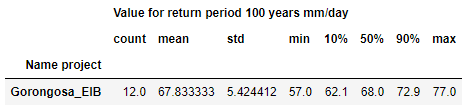

df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_future
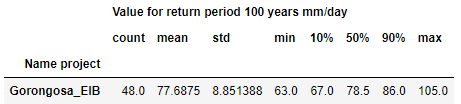

In [31]:
changes_past_future_indicator_100year_event_pr=changes_in_indicators(df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_past,df_stat_distr_100year_event_pr_NEXGDDPCMIP6_gorongosa_future,'100 year event', 'mm','Extreme rainfall change')

changes_past_future_indicator_100year_event_pr
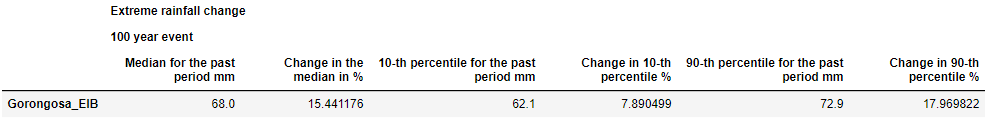

In [32]:
df_pr=pd.concat([df_pr,changes_past_future_indicator_100year_event_pr],axis=1)

#### Risk

In [ ]:
# as the elements of the project is not vulnerable regarding yearly temperature, no need to do risk assessment
(proba_event_accross_model_and_ssp_gorongosa_pr_100yearevent,likelihood_accross_model_and_ssp_gorongosa_pr_100yeareven)=likelihood_accross_models_and_ssps(df_return_period_pr_future.reset_index(),'pr','mm_per_5day','Yearly average temperature',68,'>')

### Future return period of one day rainfall event with a current return of 100 years

In [ ]:
df_=dataframe_return_period_coresponding_to_past_100year_event_model(df_pr_NEXGDDPCMIP6_gorongosa_future.dropna(),'Mean of the daily precipitation rate mm_per_day',df_return_period_pr_past)

In [ ]:
df_

### Exposure for precipitation

In [35]:
ExposureLevel_pr = level_exposure(df_pr)
df_sen = sensitivity()
df_v_pr = vulnerability(df_sen,ExposureLevel_pr)

For project Gorongosa_EIB, climate variable Extreme rainfall change
[('Extreme rainfall change', 'Maximum five days rainfall', 'Change in 10-th percentile %')]
-1.4896837442156734
<class 'numpy.float64'>
For project Gorongosa_EIB, climate variable Extreme rainfall change
[('Extreme rainfall change', '100 year event', 'Change in 10-th percentile %')]
7.890499194847019
<class 'numpy.float64'>
For project Gorongosa_EIB, climate variable Incremental rainfall change
[('Incremental rainfall change', 'Monthly average precipitation during wet season', 'Change in 10-th percentile %')]
-39.202630489390025
<class 'numpy.float64'>
Gorongosa_EIB
No exposure
Medium exposure
No exposure
Medium exposure
No exposure
Medium exposure
No exposure
Medium exposure


ExposureLevel_pr
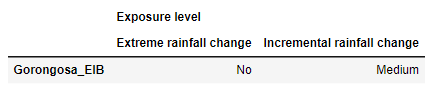

df_v_pr
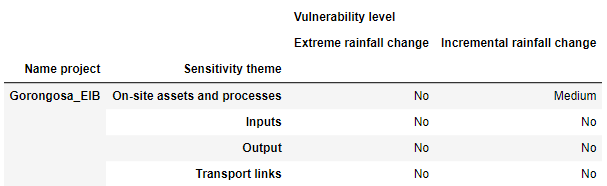

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

In [ ]:
def convert_wind_unit(i):
    # convert wind unit from m.s-1 too km per h
    i = i*3.6
    return i

In [ ]:
# import data
df_Wind_NEXGDDPCMIP6=import_treat_modeled_NEX_GDDP_CMIP6('sfcWind','m_s-1','day',1950,2100)
df_Wind_NEXGDDPCMIP6[['Daily-Mean Near-Surface Wind Speed m_s-1']]=df_Wind_NEXGDDPCMIP6[['Daily-Mean Near-Surface Wind Speed m_s-1']].applymap(convert_wind_unit)
df_Wind_NEXGDDPCMIP6_gorongosa_past = filter_dataframe(df_Wind_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=1970,stop_y=2014)
df_Wind_NEXGDDPCMIP6_gorongosa_future = filter_dataframe(df_Wind_NEXGDDPCMIP6,['Gorongosa_EIB'],['TaiESM1','CMCC-CM2-SR5','NESM3'],start_y=2030,stop_y=2074)

<a id='humidity'></a>
## Humidity

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Relative humidity

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Extraction of Relative humidity data

In [ ]:
global_variable = 'Relative_Humidity'
name_variable = 'near_surface_relative_humidity' # only available on a monthly basis

#### Historical data

#### Projections

<a id='solar_radiation'></a>
## Solar radiation

In [ ]:
global_variable = 'Solar_radiation'
# choose of the climate variable from copernicus to represent : choose of surface_downwelling_shortwave_radiation because
# 1. interest for project located at the surface of the Earth
# 2. for most project (for example solar panels), we are interest in radiation going down, not up
# 3. Shortwave radiation are the ones produce by the sun
name_variable = 'surface_downwelling_shortwave_radiation' # only available on a monthly basis

#### Historical data for solar radiation

#### Projection for data solar radiation

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()

## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='relative_sea_level_rise'></a>
## Relative sea level rise

In [ ]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview

<a id='sea_water_temperature'></a>
## Sea water temperature

In [ ]:
global_variable = 'Sea_water_temperature'
name_variable = 'sea_surface_temperature' # only estimate for the surface in the copernicus CMIP6

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2014)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection data

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='water_availability'></a>
### Water availability
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

In [ ]:
## Projection of water stress
# register path to water stress data
water_stress_location_path=os.path.join(data_folder,'Water_Availability_WaterStress/aqueduct_projections_20150309_shp/aqueduct_projections_20150309.shp')
# register data in default projection 4326
water_stress = gpd.read_file(water_stress_location_path).to_crs(bCRS) # uncertain that projeciton is the default one
ws_geometry = water_stress.geometry # register geometry for later
# filter columns of dataframe that are not water stress related
elements_to_drop=('sv','ut','bt','r','u','c','20','BasinID','dwnBasinID','Shape_Leng','Shape_Le_1') # if a column contains a str in this list, the column should be drop
# 20 to remove the projections for 2020 (the projections were made in 2015)

for name_column_out in elements_to_drop:
    water_stress=water_stress.drop(water_stress.filter(regex=name_column_out).columns, axis=1)
    
# making name of columns more precise
# information on column names come from 
#\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615
scenarios_ws=['ssp2_rcp45','ssp2_rcp85','ssp3_rcp85']
projections_ws = ['projection_2030 ','projection_2040 ']
old_name = ['ws', '30','40','24','28','38','tl']
new_name = ['water stress ','projection_2030 ','projection_2040 ','ssp2_rcp45','ssp2_rcp85','ssp3_rcp85','']

for o,n in zip(old_name,new_name): # iterate accross the two list at a time
    water_stress.columns = water_stress.columns.str.replace(o, n) # replacing "40" by "projection_2040" in names of columns
        
# water_stress is a panda dataframe, not geopanda.dataframe. Need to convert it again in geopandas.geodataframe.GeoDataFrame. 
# Otherwise, impossible to use sjoin later
water_stress = GeoDataFrame(water_stress, crs=bCRS, geometry=ws_geometry) # convert panda.dataframe in geopandas.geodataframe.GeoDataFrame

# join information from water stress to projects

projects=projects.sjoin(water_stress,how='left',predicate='within', lsuffix="_left") # need to rename name of columns to make it understandable
projects.drop('index_right', axis=1, inplace=True) # drop column containing index from water stress
projects # projects stays a geopandas.geodataframe.GeoDataFrame

In [ ]:
Display_map_projects(projects,study_area,'water stress','Map presenting water stress projections for Mozambique projects', 2, 3, out_path)
# This function aims to display every projects wanted by the user with a map as a background
### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

In [ ]:
# select climate variable to be represented
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 
# the list column_to_represent and insert \n to do a back to line
number_plots = len(columns_to_represent)

# create figure
fig, axs = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(8,8))

color_dict = {'Low':'green', 'Antarctica':'white', 'Asia':'pink', 
              'Europe':'green', 'North America':'brown',
              'Oceania':'blue', 'Seven seas (open ocean)':'gray',
              'South America':'red'}

# map in the subplot
k = 0

for i in np.arange(0,3):# columns
    for j in np.arange(0,2): # lines
        base = study_area.plot(ax=axs[j][i],color='white', edgecolor='black')# background is map of the study area presenting 
        # country borders of this area
        projects.plot(ax=axs[j][i], column=columns_to_represent[k])# plot the projects as points; legeng = True 
        # impose a color for the projects point depending on the value in the column
        
        # give subplot a title
        ax_created = axs[j][i]
        ax_created.title.set_text(columns_to_represent2[k])
        
        k+=1 # incrementation to iterate columns_to_represent
plr
plt.suptitle('Map presenting water stress projections for Mozambique projects') # give a global name to the image
plt.savefig(os.path.join(out_path,'figures','water stress','Map presenting water stress projections for Mozambique projects'),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [ ]:
np.arange(0,3)

In [ ]:
axs

In [ ]:
projects

In [ ]:
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
columns_to_represent=[ (' ').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from the list column_to_represent

In [ ]:
columns_to_represent

In [ ]:
[s.replace('water stress ', '') for s in columns_to_represent]
columns_to_represent

In [ ]:
# plot results for projects
columns_to_represent= list(projects.filter(regex='water stress').columns) # select columns that should be presented in plots
number_plots = len(columns_to_represent)

# trying to do a map with shape of area and points projets
#projects.plot(column='water stress projection_2030 ssp2_rcp45', legend=True)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(8,8))
#norm = plt.colors.Normalize(vmin=projects.val.min(), vmax=projects.val.max()) # to normalize legend between the different plots
# wait to see if new intallation worked
base = study_area.plot(ax=ax1,color='white', edgecolor='black')
projects.plot(ax=ax1, column='water stress projection_2030 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax2,color='white', edgecolor='black')
projects.plot(ax=ax2, column='water stress projection_2040 ssp2_rcp45',legend=True)
base = study_area.plot(ax=ax3,color='white', edgecolor='black')
projects.plot(ax=ax3, column='water stress projection_2030 ssp2_rcp85',legend=True)
#projects.plot(column='water stress projection_2030 ssp2_rcp45',ax=base, legend=True);

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')